In [1]:
import numpy as np
from astropy import units as u
from snewpy.models import presn, ccsn
from snewpy.neutrino import Flavor

import pylab as plt
from contextlib import contextmanager
plt.style.use('seaborn-talk')

In [2]:
@contextmanager
def raises(exception):
    "A small utility to catch and show the exceptions"
    try:
        yield
    except exception as e:
        print(f'{exception.__name__}: {e}')
    

# Usage of flux.Container interface

## 1. Initialize model

In [3]:
model = ccsn.Bollig_2016(progenitor_mass=27<<u.Msun)

times    = model.time #np.linspace(0,2,1500)<<u.second;
energies = np.linspace(0,50,501)<<u.MeV

## 2. Calculate flux

In [4]:
flux = model.get_flux(t = times, E = energies, distance=10<<u.kpc)

/home/ash/work/snews2/snewpy/python/snewpy/models/base.py:305: RuntimeWarning: divide by zero encountered in log
  np.exp(np.log(L) - (2+a)*np.log(Ea) + (1+a)*np.log(1+a)
/home/ash/work/snews2/snewpy/python/snewpy/models/base.py:305: RuntimeWarning: invalid value encountered in subtract
  np.exp(np.log(L) - (2+a)*np.log(Ea) + (1+a)*np.log(1+a)
/home/ash/work/snews2/snewpy/python/snewpy/models/base.py:306: RuntimeWarning: divide by zero encountered in true_divide
  - loggamma(1+a) + a*np.log(E) - (1+a)*(E/Ea)) / (u.erg * u.s)


## Working with the Container class

The container class is defined in `snewpy.flux.Container`

In [5]:
from snewpy.flux import Container

Container?

Init signature:
Container(
    data: astropy.units.quantity.Quantity,
    flavor: List[snewpy.neutrino.Flavor],
    time: typing.Annotated[astropy.units.quantity.Quantity, Unit("s")],
    energy: typing.Annotated[astropy.units.quantity.Quantity, Unit("MeV")],
    *,
    integrable_axes: Optional[Set[snewpy.flux.Axes]] = None,
)
Docstring:     
base class for internal use
:noindex:
Init docstring:
A container class storing the physical quantity (flux, fluence, rate...), which depends on flavor, time and energy.

Parameters
----------
data: :class:`astropy.Quantity`
    3D array of the stored quantity, must have dimensions compatible with (flavor, time, energy)

flavor: list of :class:`snewpy.neutrino.Flavor`
    array of flavors (should be ``len(flavor)==data.shape[0]``

time: array of :class:`astropy.Quantity`
    sampling points in time (then ``len(time)==data.shape[1]``) 
    or time bin edges (then ``len(time)==data.shape[1]+1``) 

energy: array of :class:`astropy.Quantity`
    samp

### Inspection

We will use the flux container, obtained from the SupernovaModel on the previous step.

On print the Container gives an output, describing it's `array` dimensions, unit (here it's `[1/(cm2 MeV s)]`), and the range of each of three axes: `flavor`, `time` and `energy`

In [6]:
print(flux)

d2FdEdT (4, 9850, 501) [1 / (cm2 MeV s)]: <4 flavor(0;3) x 9850 time(-0.34462761827 s;8.350202515285 s) x 501 energy(0.0 MeV;50.0 MeV)>


One can access the array, as a `astropy.Quantity` object:

In [7]:
flux.array

<Quantity [[[0.00000000e+000, 0.00000000e+000, 0.00000000e+000, ...,
             0.00000000e+000, 0.00000000e+000, 0.00000000e+000],
            [0.00000000e+000, 0.00000000e+000, 0.00000000e+000, ...,
             0.00000000e+000, 0.00000000e+000, 0.00000000e+000],
            [0.00000000e+000, 0.00000000e+000, 0.00000000e+000, ...,
             0.00000000e+000, 0.00000000e+000, 0.00000000e+000],
            ...,
            [2.22287829e-030, 3.28867822e+005, 1.66173852e+006, ...,
             2.35533785e+002, 2.26352262e+002, 2.17526554e+002],
            [2.16041937e-030, 3.27965908e+005, 1.65803938e+006, ...,
             2.34646226e+002, 2.25497028e+002, 2.16702481e+002],
            [2.10329974e-030, 3.27240025e+005, 1.65518049e+006, ...,
             2.33412904e+002, 2.24308702e+002, 2.15557527e+002]],

           [[0.00000000e+000, 0.00000000e+000, 0.00000000e+000, ...,
             0.00000000e+000, 0.00000000e+000, 0.00000000e+000],
            [0.00000000e+000, 0.00000000e+0

and individual axes

In [8]:
flux.energy

<Quantity [ 0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,
            1. ,  1.1,  1.2,  1.3,  1.4,  1.5,  1.6,  1.7,  1.8,  1.9,
            2. ,  2.1,  2.2,  2.3,  2.4,  2.5,  2.6,  2.7,  2.8,  2.9,
            3. ,  3.1,  3.2,  3.3,  3.4,  3.5,  3.6,  3.7,  3.8,  3.9,
            4. ,  4.1,  4.2,  4.3,  4.4,  4.5,  4.6,  4.7,  4.8,  4.9,
            5. ,  5.1,  5.2,  5.3,  5.4,  5.5,  5.6,  5.7,  5.8,  5.9,
            6. ,  6.1,  6.2,  6.3,  6.4,  6.5,  6.6,  6.7,  6.8,  6.9,
            7. ,  7.1,  7.2,  7.3,  7.4,  7.5,  7.6,  7.7,  7.8,  7.9,
            8. ,  8.1,  8.2,  8.3,  8.4,  8.5,  8.6,  8.7,  8.8,  8.9,
            9. ,  9.1,  9.2,  9.3,  9.4,  9.5,  9.6,  9.7,  9.8,  9.9,
           10. , 10.1, 10.2, 10.3, 10.4, 10.5, 10.6, 10.7, 10.8, 10.9,
           11. , 11.1, 11.2, 11.3, 11.4, 11.5, 11.6, 11.7, 11.8, 11.9,
           12. , 12.1, 12.2, 12.3, 12.4, 12.5, 12.6, 12.7, 12.8, 12.9,
           13. , 13.1, 13.2, 13.3, 13.4, 13.5, 13.6, 13.7, 13.8, 13.9,
      

### Slicing

Flux can be sliced the same way as a usual np.array:

In [9]:
#get the flux for specific flavor
flux[Flavor.NU_E] 

d2FdEdT (1, 9850, 501) [1 / (cm2 MeV s)]: <1 flavor(2;2) x 9850 time(-0.34462761827 s;8.350202515285 s) x 501 energy(0.0 MeV;50.0 MeV)>

In [10]:
#Or a trim the time or energy dimensions, 
#here we take first 1000 points in time
flux[:,:1000,:]

d2FdEdT (4, 1000, 501) [1 / (cm2 MeV s)]: <4 flavor(0;3) x 1000 time(-0.34462761827 s;0.395847790315 s) x 501 energy(0.0 MeV;50.0 MeV)>

### Summation

Container can be summed by any of the axes: `flavor`,`time`,`energy`.

In [11]:
#Sum over all flavors
flux.sum('flavor')

d2FdEdT (1, 9850, 501) [1 / (cm2 MeV s)]: <2 flavor(0;3) x 9850 time(-0.34462761827 s;8.350202515285 s) x 501 energy(0.0 MeV;50.0 MeV)>

In [12]:
#trying to summ over time or flavor will raise an exception
with raises(ValueError):
    flux.sum('time')

ValueError: Cannot sum over time! Valid axes are {<Axes.flavor: 0>}


### Integration
Also it can be integrated (using linear interpolation between points)

In [13]:
#Integrate over the full range, if limits are not provided
flux.integrate('energy')

dFdT (4, 9850, 1) [1 / (cm2 s)]: <4 flavor(0;3) x 9850 time(-0.34462761827 s;8.350202515285 s) x 2 energy(0.0 MeV;50.0 MeV)>

In [14]:
#Integrate over the first second of the flux
flux.integrate('time',limits=[0,1]<<u.s)

dFdE (4, 1, 501) [1 / (cm2 MeV)]: <4 flavor(0;3) x 2 time(0.0 s;1.0 s) x 501 energy(0.0 MeV;50.0 MeV)>

In [15]:
#Integrate over the several time bins
flux.integrate('time',limits=[0,1,2,3]<<u.s)

dFdE (4, 3, 501) [1 / (cm2 MeV)]: <4 flavor(0;3) x 4 time(0.0 s;3.0 s) x 501 energy(0.0 MeV;50.0 MeV)>

After integration, the time dimension of the array here is `len(limits)-1`
But the corresponding axis (in this case `time`) keeps all the limits (and here it has 4 points)

### "Summable" and "integrable" axes

Container will automatically watch which axes can be integrated, and which can only be summed over.

For example, the flux, obtained from the `SupernovaModel.get_flux` is differential over time and energy, which means it can be integrated over `energy` and `time`. 
You can see it from the class name `d2FdEdT` and the unit:

In [16]:
flux

d2FdEdT (4, 9850, 501) [1 / (cm2 MeV s)]: <4 flavor(0;3) x 9850 time(-0.34462761827 s;8.350202515285 s) x 501 energy(0.0 MeV;50.0 MeV)>

Internally the axes which can be summed or integrated are kept in the private properties:

In [17]:
print(f'Can integrate over {flux._integrable_axes}')
print(f'Can sum over {flux._sumable_axes}')

Can integrate over {<Axes.time: 1>, <Axes.energy: 2>}
Can sum over {<Axes.flavor: 0>}


After the integration over the axis, it becomes "summable":

In [18]:
fI = flux.integrate('time',limits=[0,1,2,3]<<u.s)
print(f'Can integrate over {fI._integrable_axes}')
print(f'Can sum over {fI._sumable_axes}')

Can integrate over {<Axes.energy: 2>}
Can sum over {<Axes.flavor: 0>, <Axes.time: 1>}


In [19]:
#after we integrated over time we can sum over the time bins
fI.sum('time')

dFdE (4, 1, 501) [1 / (cm2 MeV)]: <4 flavor(0;3) x 2 time(0.0 s;3.0 s) x 501 energy(0.0 MeV;50.0 MeV)>

In [20]:
#but cannot integrate over time again
with raises(ValueError):
    fI.integrate('time')

ValueError: Cannot integrate over time! Valid axes are {<Axes.energy: 2>}


**Note**: *integration changes the physical unit, summation or slicing do not*

### Integrate or sum (project?)

Sometimes you just want a projection of your flux to a specific axis (say, time).
In this case you want to integrate over energy if it's integrable, or just sum over the energy bins, if it is already integral flux:

In [21]:
assert fI.integrate_or_sum('energy') == fI.integrate('energy')
assert fI.integrate_or_sum('time') == fI.sum('time')

## 3. Calculate rate

I made a `RateCalculator` -  subclass of a `SimpleRate` (temporary solution for cleanness, we might merge them later).

The main difference - it uses `RateCalculator.run` function to calculate rates - multiplying flux by the cross-section, target number, smearing matrix and efficiency.

**Note** on the rate calculation:
In `SimpleRate` we used an input from `generate_fluence`, so the flux was already integrated within the energy bins, and the cross-section was sampled in the centers of energy bins.

In the `RateCalculator` we're multiplying the flux by the cross-section, and only after that we integrate over energy bins, so that should be more precise.

In [22]:
from snewpy.rate_calculator import RateCalculator
rc = RateCalculator()

In [23]:
#calculate time differential rate 
rates = rc.run(flux, 'icecube')
rates['ibd']

/home/ash/work/snews2/snewpy/python/snewpy/rate_calculator.py:42: RuntimeWarning: divide by zero encountered in log
  xsecs = np.interp(np.log(E)/np.log(10), xp, yp, left=0, right=0)*E*1e-38 <<u.cm**2


Container[cm2 / (cm2 s)] (1, 9850, 200) [cm2 / (cm2 s)]: <1 flavor(1;1) x 9850 time(-0.34462761827 s;8.350202515285 s) x 201 energy(0.0005 GeV;0.1 GeV)>

`RateCalculator.run` outputs a dictionary of Container objects with rates for each channel

Since rhe rate calculation only operates on energy, the time structure remains the same: if it was flux (`1/(MeV cm2 s)`) the rate will be `1/s`

But if we pass a flux integrated over time (fluence), we get just number of events:

In [24]:
#calculate time integral rate 
fluence = flux.integrate('time', np.arange(0,2.1,0.1)<<u.s)
ratesI = rc.run(fluence, 'icecube')
ratesI['ibd']

Container[cm2 / cm2] (1, 20, 200) [cm2 / cm2]: <1 flavor(1;1) x 21 time(0.0 s;2.0 s) x 201 energy(0.0005 GeV;0.1 GeV)>

### Saving and loading

In [25]:
#Container can be saved to a file 
fluence.save('fluence.npz')
#and loaded using the class method
fluence1 = Container.load('fluence.npz')
assert fluence1 == fluence

fluence1

dFdE (4, 20, 501) [1 / (cm2 MeV)]: <4 flavor(0;3) x 21 time(0.0 s;2.0 s) x 501 energy(0.0 MeV;50.0 MeV)>

## 4. Plotting examples

### Utility functions

In [26]:
#Utility function to draw the flux
from snewpy.flux import Axes

def project(flux, axis, integrate=True):
    axis = Axes[axis] #convert to enum
    integrate_axis = Axes.time 
    if axis == integrate_axis:
        integrate_axis = Axes.energy 
    fI = (flux.integrate if integrate else flux.sum)(integrate_axis)
    return fI.axes[axis], fI
    
def plot_projection(flux, axis, step=False, integrate=True):
    x,fI = project(flux,axis, integrate)
    y = fI.array.squeeze().T
    if step:
        #we're dealing with bins, not points
        l = plt.step(x[:-1], y, where='pre', label=[Flavor(flv).to_tex() for flv in flux.flavor])
    else:
        l = plt.plot(x, y, label=[Flavor(flv).to_tex() for flv in flux.flavor])
    
    plt.ylabel(f'{fI.__class__.__name__},  {y.unit}')
    plt.xlabel(f'{Axes[axis].name},  {x.unit}')
    return l

In [27]:
#Utility function to draw the 
def plot_rates(rates):
    for ch,r in rates.items():
        rT = r.sum('energy')

        plt.plot(rT.time, rT.array.squeeze(), label=ch)
    #plt.xlim(right=0.5)
    plt.ylabel(f'{rT.__class__.__name__},  {r.array.unit}')
    plt.xlabel(f'time, {rT.time.unit}')
    


### Plot fluxes

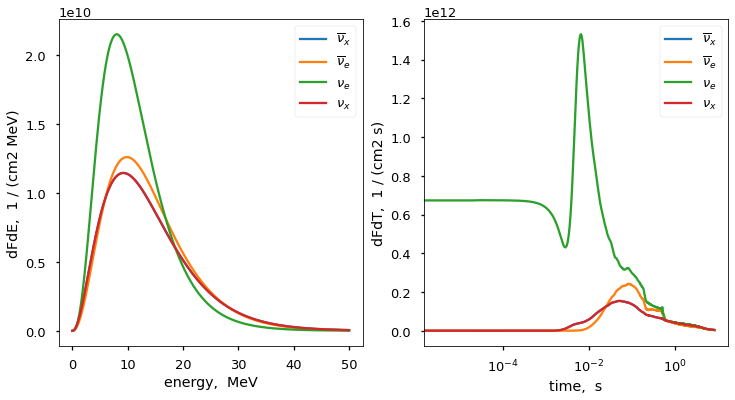

In [28]:
#plot the neutrino flux 
fig,ax = plt.subplots(1,2, figsize=(12,6))
plt.sca(ax[0])
plot_projection(flux, 'energy', integrate=True)
plt.legend()

plt.sca(ax[1])
plot_projection(flux, 'time', integrate=True)
plt.legend()
plt.xscale('log')
plt.show()

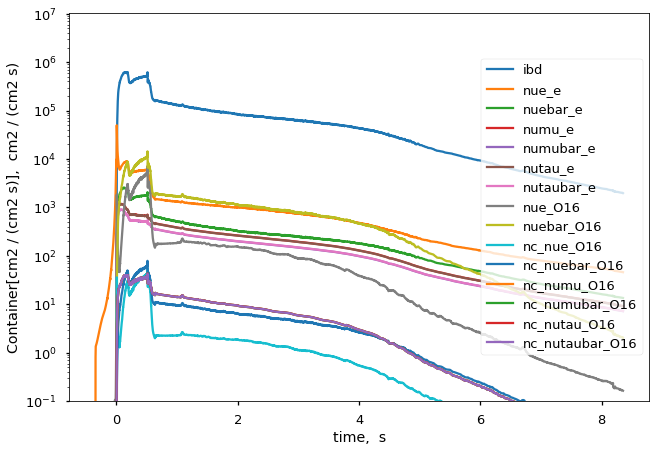

In [29]:
for ch, rate in rates.items():
    l = plot_projection(rate, 'time', integrate=False)
    l[0].set_label(ch)
plt.yscale('log')
plt.legend(loc='right')
plt.ylim(0.1)
plt.show()

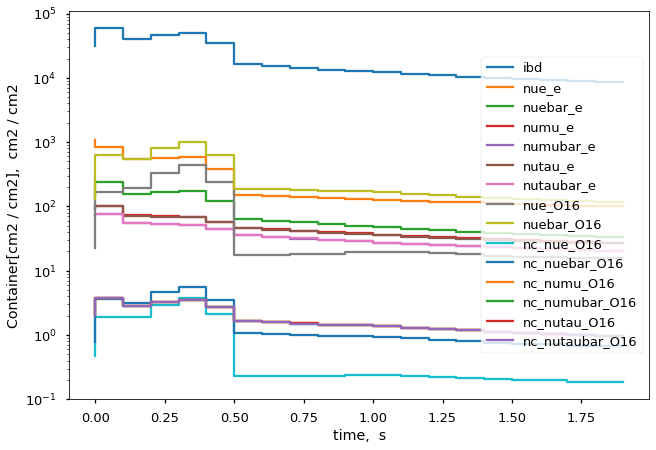

In [30]:
for ch, rate in ratesI.items():
    l = plot_projection(rate, 'time', integrate=False, step=True)
    l[0].set_label(ch)
plt.yscale('log')
plt.legend(loc='right')
plt.ylim(0.1)
plt.show()